### Prepare Workspace

In [10]:
# Import system libraries
import os
import sys

# Import data cleaning libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime

# Import machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
import shap

# Import data visualisation libraries
import matplotlib.pyplot as plt 

# Import warning libraries
import warnings
warnings.filterwarnings("ignore")

# Set working directory
os.chdir('/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/')
sys.path.insert(0, '/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/pipeline')

# Import preprocessing libraries
from preprocessing import cleaning
from preprocessing import feature_engineering
from preprocessing import scaling
from preprocessing import feature_selection

# Preprocess data
train_path = "data/Train.csv"
test_path = "data/Test.csv"
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)
df = scaling.scale_features(df)
df = feature_selection.select_features(df)

# Split data into training and test sets
df_train = df[df['Yield'].isna() == False]
df_test = df[df['Yield'].isna() == True]

### Build Yield Generic Yield Per Acre Model

Root Mean Squared Error: 135.26873656226948


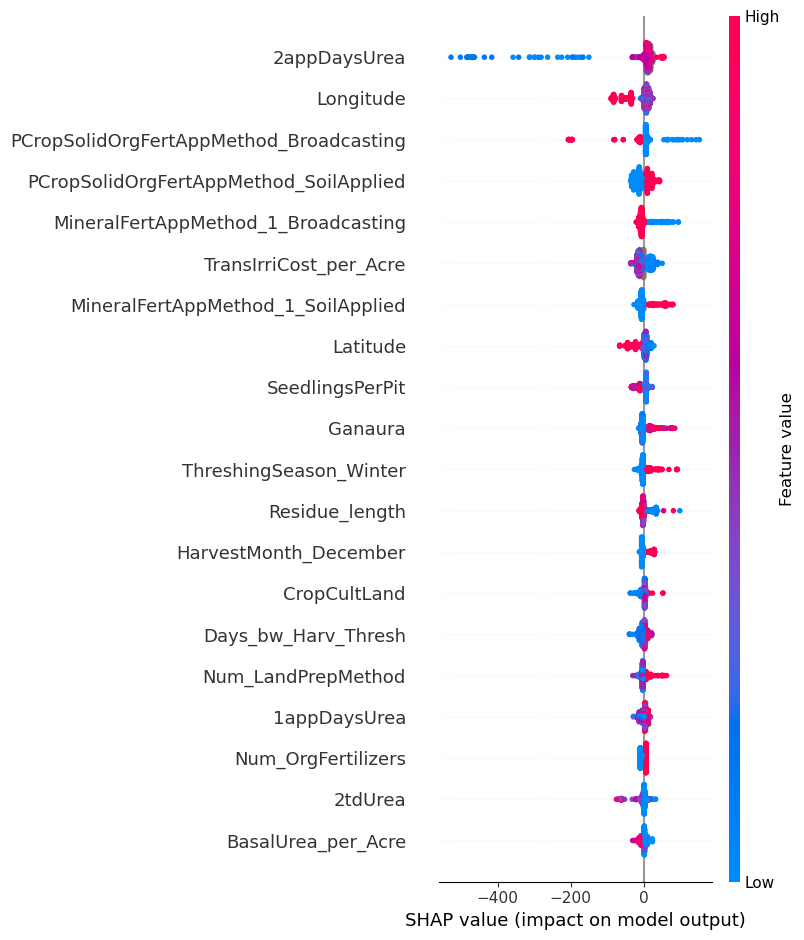

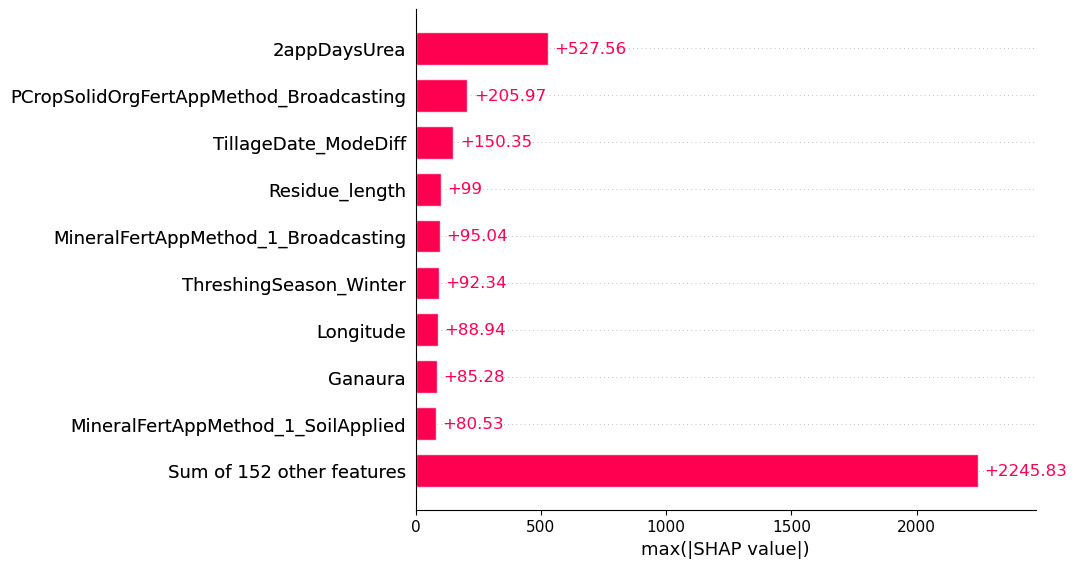

In [2]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                          learning_rate = 0.1, max_depth = 5, alpha = 10,
                          n_estimators = 10)

# Train the XGBoost model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# # Define the number of folds for cross-validation
# num_folds = 20

# # Split data into two folds
# fold_size = len(X) // num_folds
# for i in range(num_folds):
#     # Define the training and testing indices for this fold
#     test_indices = list(range(i * fold_size, (i + 1) * fold_size))
#     train_indices = [idx for idx in range(len(X)) if idx not in test_indices]

#     # Split the data into training and testing sets for this fold
#     X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
#     y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
# # Train your model on the training set
# xg_reg.fit(X_train, y_train)

# # Predict on the test set
# y_pred = xg_reg.predict(X_test)

# # Calculate and print the evaluation metric (e.g., RMSE)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"Fold {i+1} RMSE: {rmse}")

# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
sample_index = 0
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapley values
shap.summary_plot(shap_values, X_test)
shap.plots.bar(explainer(X_test).abs.max(0))

### Make Predictions

In [3]:
# Retrain model on entire training data
xg_reg.fit(X, y)
print("---Training complete---")

---Training complete---


In [4]:
# Make predictions
test_predictors = df_test.drop(outcome_cols, axis=1)
test_pred = xg_reg.predict(test_predictors) * df_test["Acre"]

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = test_pred
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

### Test Ideas

In [5]:
missing_values_count = df.isnull().sum()

for column, count in missing_values_count.items():
    print(f"Column '{column}' has {count} missing values.")

Column 'CultLand' has 0 missing values.
Column 'CropCultLand' has 0 missing values.
Column 'CropTillageDepth' has 0 missing values.
Column 'SeedlingsPerPit' has 392 missing values.
Column 'TransplantingIrrigationHours' has 270 missing values.
Column 'TransIrriCost' has 1199 missing values.
Column 'StandingWater' has 317 missing values.
Column 'Ganaura' has 0 missing values.
Column 'CropOrgFYM' has 0 missing values.
Column 'NoFertilizerAppln' has 0 missing values.
Column 'BasalDAP' has 0 missing values.
Column 'BasalUrea' has 0 missing values.
Column '1tdUrea' has 0 missing values.
Column '1appDaysUrea' has 733 missing values.
Column '2tdUrea' has 0 missing values.
Column '2appDaysUrea' has 3569 missing values.
Column 'Harv_hand_rent' has 0 missing values.
Column 'Residue_length' has 0 missing values.
Column 'Residue_perc' has 0 missing values.
Column 'Acre' has 0 missing values.
Column 'Yield' has 1290 missing values.
Column 'Nb_of_NaN' has 0 missing values.
Column 'TpIrrigationHours_I

In [8]:
from sklearn.decomposition import PCA

# Identify predictors with no missing data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
missing = ['SeedlingsPerPit','TransIrriCost','StandingWater','1appDaysUrea',
           '2appDaysUrea','TransplantingIrrigationHours_per_Acre','']
X = df_train.drop(outcome_cols + missing, axis=1)

# Initialize PCA with the number of components you want to retain
n_components = 4  # Set the number of components here
pca = PCA(n_components=n_components)

# Assuming X is your feature matrix
# You may need to preprocess your data before passing it into PCA
# Fill missing values, scale your data, etc.
X = df.dropna()  # Remove rows with missing values

# Fit and transform the data
pca.fit(X)
X_pca = pca.transform(X)

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:")
for i, evr in enumerate(explained_variance_ratio):
    print(f"Component {i + 1}: {evr:.4f}")
    
# Create column names for the new principal components
pc_columns = [f"PC{i+1}" for i in range(n_components)]

# Create a DataFrame for the principal components
df_pca = pd.DataFrame(data=X_pca, columns=pc_columns, index=X.index)

# Concatenate the principal components DataFrame with your original DataFrame
#df_with_pca = pd.concat([df, df_pca], axis=1)

Explained variance ratio for each component:
Component 1: 0.7384
Component 2: 0.2096
Component 3: 0.0519
Component 4: 0.0000


In [40]:
df_pca

,PC1,PC2,PC3
10,1090.729367,-597.575228,2.364732
13,212.537888,-257.238506,14.840938
14,-404.847419,247.803945,-22.199728
22,1232.676000,-209.618037,-76.004665
24,-2447.754030,-366.155036,249.116582
...,...,...,...
3848,974.085576,-814.871023,49.269644
3851,212.537480,-257.238268,14.841806
3860,-2446.430434,-368.642132,249.436579
3862,1.231420,139.650974,-36.451874


In [9]:
# Calculate mean of each column in the shap_values matrix
column_means = np.mean(shap_values, axis=0)

# Attach mean values to column names
column_means_with_names = {column: mean for column, mean in zip(X.columns, column_means)}

# Display column names with their mean values
for column, mean in column_means_with_names.items():
    print(f"{column}: {mean}")

CultLand: -0.11916788667440414
CropCultLand: 0.48876845836639404
CropTillageDepth: 1.2070658206939697
SeedlingsPerPit: 0.5156427025794983
TransplantingIrrigationHours: -0.03484385088086128
TransIrriCost: -0.010399268940091133
StandingWater: -1.2623933553695679
Ganaura: -0.09061281383037567
CropOrgFYM: 0.17311035096645355
NoFertilizerAppln: -0.13729339838027954
BasalDAP: 0.0
BasalUrea: 0.0756390318274498
1tdUrea: 0.2713451087474823
1appDaysUrea: 0.9972175359725952
2tdUrea: 0.00658424710854888
2appDaysUrea: -8.39331340789795
Harv_hand_rent: -0.13967600464820862
Residue_length: 1.6539134979248047
Residue_perc: 0.0
Acre: 0.3346126973628998
Yield: 0.06189992278814316
Nb_of_NaN: 0.0
TpIrrigationHours_Imputed: 0.5193368792533875
SeedlingsPerPit_Imputed: -0.5271309018135071
2appDaysUrea_Imputed: 0.0
Ganaura_capped: 0.4493175446987152
New_Yield: -0.12741544842720032
TransplantingIrrigationHours_per_Acre: -0.7494902610778809
TpIrrigationHours_Imputed_per_Acre: -0.49434947967529297
TransIrriCost_

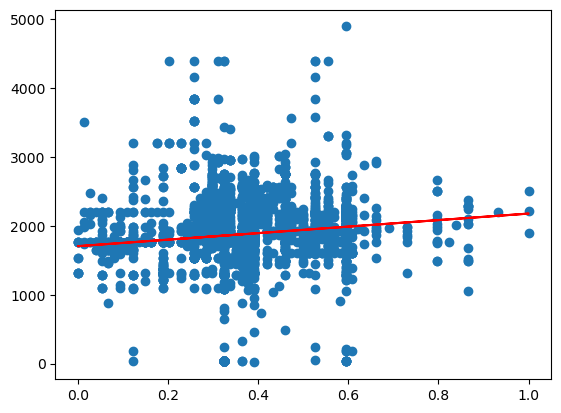

In [10]:
data = df_train[df_train['1appDaysUrea'].isna() == False]
slope, intercept = np.polyfit(data['1appDaysUrea'], data['New_Yield_per_Acre'], 1)

# Plot the line of best fit
plt.plot(data['1appDaysUrea'], slope * data['1appDaysUrea'] + intercept, color='red') 
plt.scatter(data['1appDaysUrea'], data['New_Yield_per_Acre'])

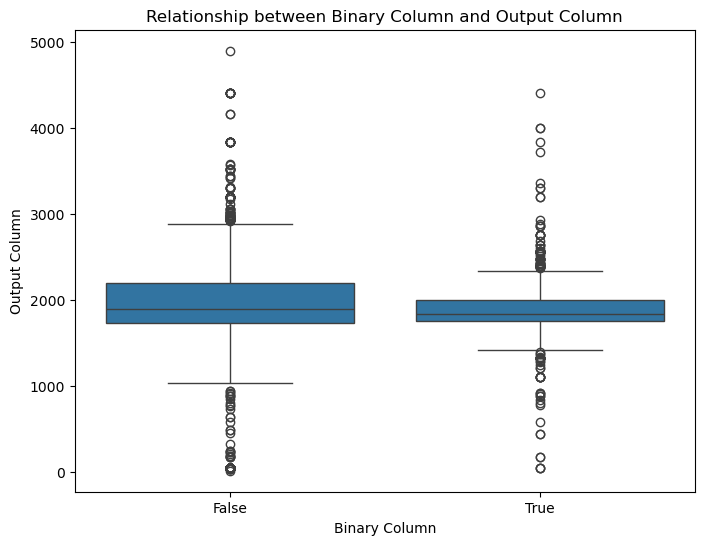

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x='1appDaysUrea_NaN', y='New_Yield_per_Acre', data=df)
plt.xlabel('Binary Column')
plt.ylabel('Output Column')
plt.title('Relationship between Binary Column and Output Column')
plt.show()